# conditional Auxillary Classifier GAN
Train an auxillary classifier GAN on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in
vaegan.gan.py, our class for loading the MNIST dataset defined in
vaegan.data, and our custom Keras callback in vaegan.conditional.callbacks.

A directory called 'output' will be created to save figures and the trained
model. 


In [1]:
nEpochs = 20  # orig, longer training
# nEpochs=3  # quick testing during development
%set_env CUDA_VISIBLE_DEVICES=1
%cd 04_ExerciseCodeAndInstructions/vaegan


env: CUDA_VISIBLE_DEVICES=1
/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/vaegan


## 1. Import 3rd party libraries 

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import our own classes
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional
from vaegan.gan import ConditionalGAN


2025-05-30 11:18:45.926846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748621925.950139   35235 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748621925.957293   35235 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748621925.975643   35235 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748621925.975660   35235 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748621925.975663   35235 computation_placer.cc:177] computation placer alr

## 3. Show some our data

I0000 00:00:1748621930.651424   35235 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11936 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


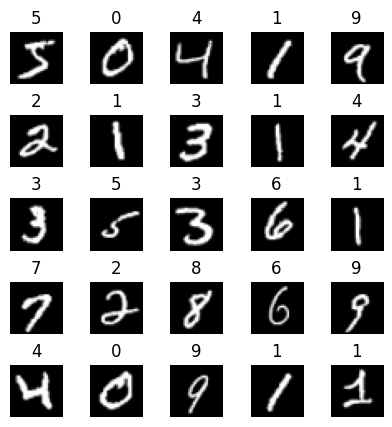

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = "./outputs/mnist_cgan"
os.makedirs(output_dir, exist_ok=True)

# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, depth=n_classes, dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, "example_images.png"))


## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = ConditionalGAN(n_classes=n_classes)

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# model.discriminator.compute_output_shape((None, 32, 32, 1))


Loaded version: vaegan.gan
Loaded version: vaegan.gan


In [5]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== GENERATOR SUBMODEL ====")
gen_in = tf.keras.layers.Input((model.n_latent_dims + n_classes,))
gen_out = model.generator.call(gen_in)
gen = tf.keras.Model(gen_in, gen_out)
gen.summary()
print("=== DISCRIMINATOR SUBMODEL ====")
disc_in = tf.keras.layers.Input(model.image_shape)
disc_out = model.discriminator.call(disc_in)
disc = tf.keras.Model(disc_in, disc_out)
disc.summary()


=== OVERALL MODEL ====


Model: "cgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator (Generator)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Discriminator)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator                   │ ?                      │   0 (unbuilt) │
│ (MultiTaskDiscriminator)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== GENERATOR SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │     1,138,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense (LeakyReLU)          │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2DTranspose)         │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (LeakyReLU)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2DTranspose)         │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (LeakyReLU)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,385 (6.35 MB)

 Trainable params: 1,664,385 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

=== DISCRIMINATOR SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        544 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        128 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (ReLU)        │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     32,832 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_real (Dense)  │ (None, 1)         │     16,385 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_class (Dense) │ (None, 10)        │    163,850 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_real        │ (None, 1)         │          0 │ dense_real[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_class       │ (None, 10)        │          0 │ dense_class[0][0] │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,995 (835.92 KB)

 Trainable params: 213,803 (835.17 KB)

 Non-trainable params: 192 (768.00 B)

## 6. Compile the model 

In [6]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = GenerateImagesConditional(
    output_dir=output_dir,
    model=model,
    example_labels=labels_onehot[:10],
    n_generated_images=10,
    n_latent_dims=model.n_latent_dims,
)


## 7. Train (fit) the model on the data 

In [7]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit(
    [data.images_train, labels_onehot],
    batch_size=128,
    epochs=nEpochs,
    callbacks=[save_images_callback],
)


Epoch 1/20


I0000 00:00:1748621937.996979   35499 service.cc:152] XLA service 0x2aae94001fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748621937.997026   35499 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-05-30 11:18:58.110593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-30 11:18:58.264480: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:132] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
I0000 00:00:1748621938.761180   35499 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-30 11:18:59.443583: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.20 = (f32[128,1,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,32,32]{3,2,1,0} %

  2/469 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - Cat_accuracy: 0.0547 - disc_loss: 4.6660 - gen_loss: 3.0463   

I0000 00:00:1748621945.010307   35499 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - Cat_accuracy: 0.4732 - disc_loss: 2.2073 - gen_loss: 2.6604

2025-05-30 11:19:27.479070: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.20 = (f32[96,1,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,128,32,32]{3,2,1,0} %bitcast.10494, f32[1,128,3,3]{3,2,1,0} %bitcast.10501, f32[1]{0} %bitcast.12683), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="generator_1/conv_out_1/convolution" source_file="/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-30 11:19:27.851503: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - Cat_accuracy: 0.4741 - disc_loss: 2.2050 - gen_loss: 2.6571
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - Cat_accuracy: 0.8659 - disc_loss: 1.5359 - gen_loss: 0.3339
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - Cat_accuracy: 0.9052 - disc_loss: 1.4503 - gen_loss: 0.3732
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - Cat_accuracy: 0.9215 - disc_loss: 1.2215 - gen_loss: 0.5062
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - Cat_accuracy: 0.9305 - disc_loss: 1.1108 - gen_loss: 0.5472
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - Cat_accuracy: 0.9390 - disc_loss: 1.0424 - gen_loss: 0.5961
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - Cat_accuracy: 0.9458 - disc_loss: 0.9818 - gen_loss: 0.7016
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - Cat_accuracy: 0.9506 - disc_loss: 0.9650 - gen_loss: 0.6189
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - Cat_accuracy: 0.9553 - disc

## 8. Training saves results to disk, now also plot training curves

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


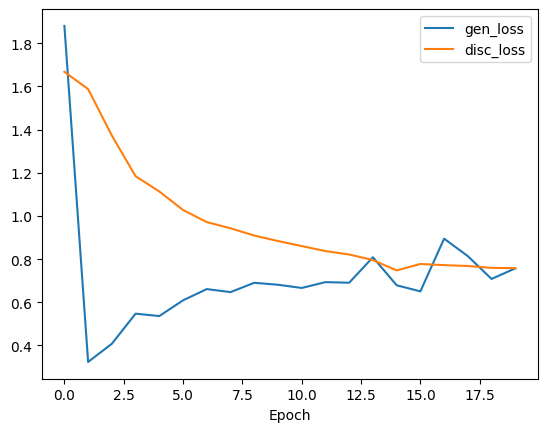

In [8]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ["gen_loss", "disc_loss"]:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)

ax.legend()
ax.set_xlabel("Epoch")
fig.savefig(os.path.join(output_dir, "training_curves.png"), transparent=False)
# fig.show()

# Save the model
model.save(os.path.join(output_dir, "cgan.keras"))
